## Importing the libraries

In [2]:
import sys
sys.setrecursionlimit(100000)

In [40]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

from folium.plugins import TimestampedGeoJson
from folium import plugins

import folium

import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt
import seaborn as sns

## Load the dataset

In [4]:
covid_data_path = '/content/drive/MyDrive/모각코/covid/coronavirusdataset_20200430'

In [5]:
data = pd.read_csv(os.path.join(covid_data_path, 'Case.csv'))

In [6]:
print(len(data.keys()))
print(data.keys())

8
Index(['case_id', 'province', 'city', 'group', 'infection_case', 'confirmed',
       'latitude', 'longitude'],
      dtype='object')


## Checking the missing data

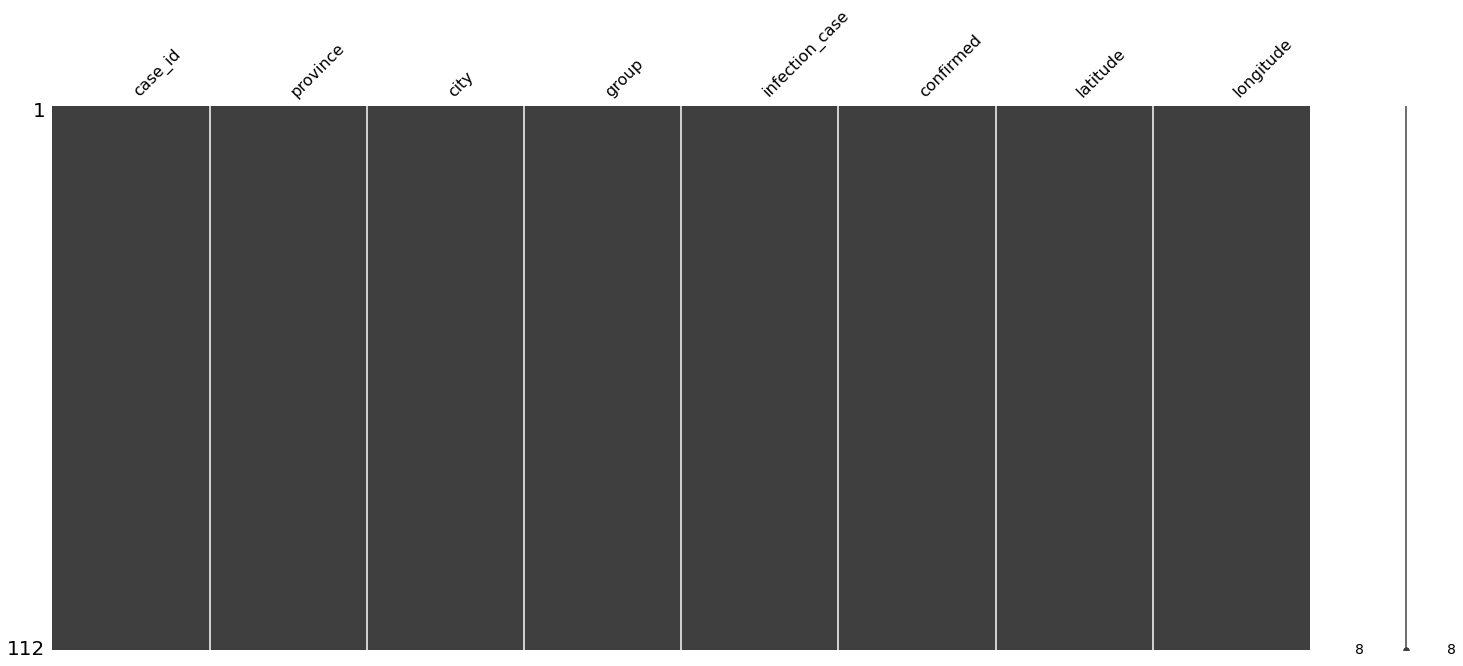

In [7]:
msno.matrix(data)

In [8]:
for c in data.columns:
  print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

case_id : 0
province : 0
city : 0
group : 0
infection_case : 0
confirmed : 0
latitude : 0
longitude : 0


In [9]:
data[data.keys()[6]]

0      37.508163
1      37.592888
2      37.481059
3       37.63369
4       37.55713
         ...    
107            -
108            -
109            -
110            -
111            -
Name: latitude, Length: 112, dtype: object

### Visualization

### Provenant Distribution by Province

In [10]:
import json

patientinfo_data = pd.read_csv(os.path.join(covid_data_path, 'PatientInfo.csv'))

with open(os.path.join(covid_data_path, 'korea_geojson2.geojson'), encoding='UTF-8') as f:
  data=json.load(f)

for x in data['features']:
  x['id'] = x['properties']['CTP_KOR_NM']

for idx, _ in enumerate(data['features']):
  print(data['features'][idx]['id'])

강원도
경기도
경상남도
경상북도
광주광역시
대구광역시
대전광역시
부산광역시
서울특별시
세종특별자치시
울산광역시
인천광역시
전라남도
전라북도
제주특별자치도
충청남도
충청북도


In [11]:
print(patientinfo_data['province'].unique())
print(patientinfo_data['province'].nunique())

['Seoul' 'Busan' 'Daegu' 'Gwangju' 'Incheon' 'Daejeon' 'Ulsan' 'Sejong'
 'Gyeonggi-do' 'Gangwon-do' 'Chungcheongbuk-do' 'Chungcheongnam-do'
 'Jeollabuk-do' 'Jeollanam-do' 'Gyeongsangbuk-do' 'Gyeongsangnam-do'
 'Jeju-do']
17


In [12]:
mapper = [
    ('Gyeonggi-do', '경기도'),
    ('Seoul', '서울특별시'),
    ('Chungcheongbuk-do', '충청북도'),
    ('Incheon', '인천광역시'),
    ('Chungcheongnam-do', '충청남도'),
    ('Gwangju', '광주광역시'),
    ('Busan', '부산광역시'),
    ('Gangwon-do', '강원도'),
    ('Jeollanam-do', '전라남도'),
    ('Daegu', '대구광역시'),
    ('Jeollabuk-do', '전라북도'),
    ('Ulsan', '울산광역시'),
    ('Jeju-do', '제주특별자치도'),
    ('Gyeongsangbuk-do', '경상북도'),
    ('Sejong', '세종특별자치시'),
    ('Gyeongsangnam-do', '경상남도'),
    ('Daejeon', '대전광역시'),
]

mapper = np.array(mapper).T
print(mapper)

[['Gyeonggi-do' 'Seoul' 'Chungcheongbuk-do' 'Incheon' 'Chungcheongnam-do'
  'Gwangju' 'Busan' 'Gangwon-do' 'Jeollanam-do' 'Daegu' 'Jeollabuk-do'
  'Ulsan' 'Jeju-do' 'Gyeongsangbuk-do' 'Sejong' 'Gyeongsangnam-do'
  'Daejeon']
 ['경기도' '서울특별시' '충청북도' '인천광역시' '충청남도' '광주광역시' '부산광역시' '강원도' '전라남도'
  '대구광역시' '전라북도' '울산광역시' '제주특별자치도' '경상북도' '세종특별자치시' '경상남도' '대전광역시']]


In [13]:
print(mapper[0])

region_list = []
for i in range(len(patientinfo_data['province'])):
    region_index = list(mapper[0]).index(patientinfo_data['province'][i])

    region_list.append(mapper[1][region_index])

['Gyeonggi-do' 'Seoul' 'Chungcheongbuk-do' 'Incheon' 'Chungcheongnam-do'
 'Gwangju' 'Busan' 'Gangwon-do' 'Jeollanam-do' 'Daegu' 'Jeollabuk-do'
 'Ulsan' 'Jeju-do' 'Gyeongsangbuk-do' 'Sejong' 'Gyeongsangnam-do'
 'Daejeon']


In [14]:
size_df = patientinfo_data.groupby('province').size().to_frame('pat_size')
size_df_index = list(size_df.index)

size1 = list(patientinfo_data.groupby('province').size())

region_patient = {
    'geo_region' : mapper[1]
}

region_patient_df = pd.DataFrame(region_patient)

pation_count_list = []
for name in region_patient_df['geo_region']:
    mapper1_name = mapper[0][list(mapper[1]).index(name)]

    pation_count = size_df['pat_size'][size_df_index.index(mapper1_name)]
    
    pation_count_list.append(pation_count)
    
region_patient['patient_size'] = pation_count_list

print(region_patient['geo_region'])
print(region_patient['patient_size'])

['경기도' '서울특별시' '충청북도' '인천광역시' '충청남도' '광주광역시' '부산광역시' '강원도' '전라남도' '대구광역시'
 '전라북도' '울산광역시' '제주특별자치도' '경상북도' '세종특별자치시' '경상남도' '대전광역시']
[677, 633, 45, 92, 143, 30, 134, 51, 15, 63, 17, 43, 13, 1230, 46, 116, 40]


In [15]:
patientinfo_data['geo_region'] = region_list
patientinfo_data

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,geo_region
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,서울특별시
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released,서울특별시
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released,서울특별시
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,서울특별시
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released,서울특별시
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3383,7000000009,9651.0,female,NaN,20s,Korea,Jeju-do,Jeju-do,NaN,overseas inflow,NaN,NaN,14.0,NaN,2020-03-29,NaN,NaN,isolated,제주특별자치도
3384,7000000010,NaN,female,NaN,20s,Korea,Jeju-do,Jeju-do,NaN,overseas inflow,NaN,NaN,18.0,NaN,2020-04-03,NaN,NaN,isolated,제주특별자치도
3385,7000000011,NaN,male,NaN,30s,Korea,Jeju-do,Jeju-do,NaN,contact with patient,NaN,7.000000e+09,5.0,NaN,2020-04-03,NaN,NaN,isolated,제주특별자치도
3386,7000000012,NaN,female,NaN,20s,Korea,Jeju-do,Jeju-do,NaN,overseas inflow,NaN,NaN,9.0,NaN,2020-04-03,NaN,NaN,isolated,제주특별자치도


In [16]:
fig = px.choropleth_mapbox(
   region_patient, 
   geojson=data, 
   locations='geo_region', 
   color='patient_size',
   color_continuous_scale=px.colors.sequential.Redor,
   # featureidkey="properties.CTP_KOR_NM", # featureidkey를 사용하여 id 값을 갖는 키값 지정
   mapbox_style="carto-positron",
   zoom=5.5, 
   center = {"lat": 35.757981, "lon": 127.661132},
   opacity=0.6,
   labels={'patient_size':'확진자 수'}
)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

#### HeatMap 

In [17]:
Region_data = pd.read_csv(os.path.join(covid_data_path, 'Region.csv'))

In [18]:
Region_data.head()

,code,province,city,latitude,longitude,elementary_school_count,kindergarten_count,university_count,academy_ratio,elderly_population_ratio,elderly_alone_ratio,nursing_home_count
0,10000,Seoul,Seoul,37.566953,126.977977,607,830,48,1.44,15.38,5.8,22739
1,10010,Seoul,Gangnam-gu,37.518421,127.047222,33,38,0,4.18,13.17,4.3,3088
2,10020,Seoul,Gangdong-gu,37.530492,127.123837,27,32,0,1.54,14.55,5.4,1023
3,10030,Seoul,Gangbuk-gu,37.639938,127.025508,14,21,0,0.67,19.49,8.5,628
4,10040,Seoul,Gangseo-gu,37.551166,126.849506,36,56,1,1.17,14.39,5.7,1080


In [19]:
corona_region_data = Region_data[['latitude', 'longitude']]

In [20]:
corona_region_data.head()

,latitude,longitude
0,37.566953,126.977977
1,37.518421,127.047222
2,37.530492,127.123837
3,37.639938,127.025508
4,37.551166,126.849506


In [21]:
m2 = folium.Map([35.757981, 127.661132], tiles='Stamen Terrain', zoom_start=6)

folium.plugins.HeatMap(corona_region_data).add_to(m2)

m2

#### TimeStamped

In [22]:
patientinfo_data


,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,geo_region
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,서울특별시
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released,서울특별시
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released,서울특별시
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,서울특별시
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released,서울특별시
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3383,7000000009,9651.0,female,NaN,20s,Korea,Jeju-do,Jeju-do,NaN,overseas inflow,NaN,NaN,14.0,NaN,2020-03-29,NaN,NaN,isolated,제주특별자치도
3384,7000000010,NaN,female,NaN,20s,Korea,Jeju-do,Jeju-do,NaN,overseas inflow,NaN,NaN,18.0,NaN,2020-04-03,NaN,NaN,isolated,제주특별자치도
3385,7000000011,NaN,male,NaN,30s,Korea,Jeju-do,Jeju-do,NaN,contact with patient,NaN,7.000000e+09,5.0,NaN,2020-04-03,NaN,NaN,isolated,제주특별자치도
3386,7000000012,NaN,female,NaN,20s,Korea,Jeju-do,Jeju-do,NaN,overseas inflow,NaN,NaN,9.0,NaN,2020-04-03,NaN,NaN,isolated,제주특별자치도


In [23]:
Region_data


,code,province,city,latitude,longitude,elementary_school_count,kindergarten_count,university_count,academy_ratio,elderly_population_ratio,elderly_alone_ratio,nursing_home_count
0,10000,Seoul,Seoul,37.566953,126.977977,607,830,48,1.44,15.38,5.8,22739
1,10010,Seoul,Gangnam-gu,37.518421,127.047222,33,38,0,4.18,13.17,4.3,3088
2,10020,Seoul,Gangdong-gu,37.530492,127.123837,27,32,0,1.54,14.55,5.4,1023
3,10030,Seoul,Gangbuk-gu,37.639938,127.025508,14,21,0,0.67,19.49,8.5,628
4,10040,Seoul,Gangseo-gu,37.551166,126.849506,36,56,1,1.17,14.39,5.7,1080
...,...,...,...,...,...,...,...,...,...,...,...,...
239,61160,Gyeongsangnam-do,Haman-gun,35.272481,128.406540,16,20,0,1.19,23.74,14.7,94
240,61170,Gyeongsangnam-do,Hamyang-gun,35.520541,127.725177,13,12,0,1.01,32.65,20.9,83
241,61180,Gyeongsangnam-do,Hapcheon-gun,35.566702,128.165870,17,15,0,0.71,38.44,24.7,96
242,70000,Jeju-do,Jeju-do,33.488936,126.500423,113,123,4,1.53,15.10,6.4,1245


In [24]:
regional_patient = pd.merge(patientinfo_data[['patient_id','confirmed_date','sex','age','province','city']],Region_data[['province','city','latitude','longitude']], how = 'inner', on = ['province','city'])
display(regional_patient.head())
display(regional_patient.isnull().sum() / regional_patient.shape[0])
regional_patient

,patient_id,confirmed_date,sex,age,province,city,latitude,longitude
0,1000000001,2020-01-23,male,50s,Seoul,Gangseo-gu,37.551166,126.849506
1,1000000027,2020-02-23,male,50s,Seoul,Gangseo-gu,37.551166,126.849506
2,1000000106,2020-03-06,male,30s,Seoul,Gangseo-gu,37.551166,126.849506
3,1000000144,2020-03-09,female,40s,Seoul,Gangseo-gu,37.551166,126.849506
4,1000000150,2020-03-09,female,60s,Seoul,Gangseo-gu,37.551166,126.849506


patient_id        0.000000
confirmed_date    0.000922
sex               0.021826
age               0.023978
province          0.000000
city              0.000000
latitude          0.000000
longitude         0.000000
dtype: float64

,patient_id,confirmed_date,sex,age,province,city,latitude,longitude
0,1000000001,2020-01-23,male,50s,Seoul,Gangseo-gu,37.551166,126.849506
1,1000000027,2020-02-23,male,50s,Seoul,Gangseo-gu,37.551166,126.849506
2,1000000106,2020-03-06,male,30s,Seoul,Gangseo-gu,37.551166,126.849506
3,1000000144,2020-03-09,female,40s,Seoul,Gangseo-gu,37.551166,126.849506
4,1000000150,2020-03-09,female,60s,Seoul,Gangseo-gu,37.551166,126.849506
...,...,...,...,...,...,...,...,...
3248,7000000009,2020-03-29,female,20s,Jeju-do,Jeju-do,33.488936,126.500423
3249,7000000010,2020-04-03,female,20s,Jeju-do,Jeju-do,33.488936,126.500423
3250,7000000011,2020-04-03,male,30s,Jeju-do,Jeju-do,33.488936,126.500423
3251,7000000012,2020-04-03,female,20s,Jeju-do,Jeju-do,33.488936,126.500423


In [26]:
df_dropna = regional_patient.dropna()
df_dropna['timestamp'] = [i+'T00:00:00' for i in df_dropna['confirmed_date']]
df_dropna

,patient_id,confirmed_date,sex,age,province,city,latitude,longitude,timestamp
0,1000000001,2020-01-23,male,50s,Seoul,Gangseo-gu,37.551166,126.849506,2020-01-23T00:00:00
1,1000000027,2020-02-23,male,50s,Seoul,Gangseo-gu,37.551166,126.849506,2020-02-23T00:00:00
2,1000000106,2020-03-06,male,30s,Seoul,Gangseo-gu,37.551166,126.849506,2020-03-06T00:00:00
3,1000000144,2020-03-09,female,40s,Seoul,Gangseo-gu,37.551166,126.849506,2020-03-09T00:00:00
4,1000000150,2020-03-09,female,60s,Seoul,Gangseo-gu,37.551166,126.849506,2020-03-09T00:00:00
...,...,...,...,...,...,...,...,...,...
3248,7000000009,2020-03-29,female,20s,Jeju-do,Jeju-do,33.488936,126.500423,2020-03-29T00:00:00
3249,7000000010,2020-04-03,female,20s,Jeju-do,Jeju-do,33.488936,126.500423,2020-04-03T00:00:00
3250,7000000011,2020-04-03,male,30s,Jeju-do,Jeju-do,33.488936,126.500423,2020-04-03T00:00:00
3251,7000000012,2020-04-03,female,20s,Jeju-do,Jeju-do,33.488936,126.500423,2020-04-03T00:00:00


In [27]:
TimestampedGeoJson(data, transition_time=200, loop=True, auto_play=True, 
                   add_last_point=True, period='P1D', min_speed=0.1, max_speed=10, 
                   loop_button=False, date_options='YYYY-MM-DD HH:mm:ss', 
                   time_slider_drag_update=False, duration=None)

In [28]:
points = []
for date in sorted(df_dropna['confirmed_date'].unique()):
    temp = df_dropna.query('confirmed_date == @date')
    
    temp_dict = {}
    temp_dict['coordinates'] = temp[['longitude','latitude']].values.tolist()
    temp_dict['dates'] = temp['timestamp'].values.tolist()
    
    points += [temp_dict]
points[0]

{'coordinates': [[126.849506, 37.551166]], 'dates': ['2020-01-23T00:00:00']}

In [29]:
features = [ { 'type': 'Feature', 
                  'geometry': { 'type': 'MultiPoint', 
                               'coordinates': point['coordinates'], }, 
                  'properties': { 'times': point['dates'],
                                 'icon' : 'circle'}
             } for point in points ] 

In [31]:
features[:1]

[{'geometry': {'coordinates': [[126.849506, 37.551166]], 'type': 'MultiPoint'},
  'properties': {'icon': 'circle', 'times': ['2020-01-23T00:00:00']},
  'type': 'Feature'}]

In [32]:
import folium
m3 = folium.Map([35.757981, 127.661132], tiles='stamentoner', zoom_start=6,
               )

plugins.Fullscreen(position='topright',  # Full screen
                   title='Click to Expand', 
                   title_cancel='Click to Exit', 
                   force_separate_button=True).add_to(m3)

In [33]:
plugins.TimestampedGeoJson({ 
    'type': 'FeatureCollection', 
    'features': features, 
}, period='P1D', auto_play = False).add_to(m3)

m3

### Confirmed cases gender graph

In [35]:
TimeGender_data = pd.read_csv(os.path.join(covid_data_path, 'TimeGender.csv'))
TimeGender_data

,date,time,sex,confirmed,deceased
0,2020-03-02,0,male,1591,13
1,2020-03-02,0,female,2621,9
2,2020-03-03,0,male,1810,16
3,2020-03-03,0,female,3002,12
4,2020-03-04,0,male,1996,20
...,...,...,...,...,...
115,2020-04-28,0,female,6408,116
116,2020-04-29,0,male,4348,129
117,2020-04-29,0,female,6413,117
118,2020-04-30,0,male,4352,130


In [36]:
male_data = TimeGender_data.loc[0::2]
female_data = TimeGender_data.loc[1::2]

In [38]:
male_data

,date,time,sex,confirmed,deceased
0,2020-03-02,0,male,1591,13
2,2020-03-03,0,male,1810,16
4,2020-03-04,0,male,1996,20
6,2020-03-05,0,male,2149,21
8,2020-03-06,0,male,2345,25
10,2020-03-07,0,male,2522,26
12,2020-03-08,0,male,2694,29
14,2020-03-09,0,male,2799,31
16,2020-03-10,0,male,2852,33
18,2020-03-11,0,male,2947,35


In [41]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = male_data['date'] , y = male_data['confirmed'], fill='tozeroy')) # fill down to xaxis
fig.add_trace(go.Scatter(x = female_data['date'] , y = female_data['confirmed'], fill='tonexty')) # fill down to xaxis

fig.show()

In [42]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x = female_data['date'], y = female_data['confirmed'], name='female',
                         line=dict(color='firebrick', width=4)))

fig.add_trace(go.Scatter(x = male_data['date'], y = male_data['confirmed'], name = 'male',
                         line=dict(color='royalblue', width=4)))

fig.add_trace(go.Scatter(x = female_data['date'], y = female_data['deceased'], name='female',
                         line = dict(color='firebrick', width=4, dash='dot')))

fig.add_trace(go.Scatter(x = male_data['date'], y = male_data['deceased'], name='male',
                         line=dict(color='royalblue', width=4, dash='dot')))

# Edit the layout
fig.update_layout(title='성별 누적 확진자 & 누적 사망자',
                   xaxis_title='Month',
                   yaxis_title='Temperature (degrees F)')


fig.show()

In [43]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = female_data['date'], y = female_data['deceased'], name='female',
                         line = dict(color='firebrick', width=4, dash='dot')))

fig.add_trace(go.Scatter(x = male_data['date'], y = male_data['deceased'], name='male',
                         line=dict(color='royalblue', width=4, dash='dot')))

# Edit the layout
fig.update_layout(title='성별 누적 사망자',
                   xaxis_title='Month',
                   yaxis_title='Temperature (degrees F)')


fig.show()

In [44]:
print(TimeGender_data['date'][0])
print(TimeGender_data['date'][-1:])
print(TimeGender_data)

2020-03-02
119    2020-04-30
Name: date, dtype: object
           date  time     sex  confirmed  deceased
0    2020-03-02     0    male       1591        13
1    2020-03-02     0  female       2621         9
2    2020-03-03     0    male       1810        16
3    2020-03-03     0  female       3002        12
4    2020-03-04     0    male       1996        20
..          ...   ...     ...        ...       ...
115  2020-04-28     0  female       6408       116
116  2020-04-29     0    male       4348       129
117  2020-04-29     0  female       6413       117
118  2020-04-30     0    male       4352       130
119  2020-04-30     0  female       6413       117

[120 rows x 5 columns]


In [45]:
import plotly.express as px


TimeGender_confirm = list(TimeGender_data['confirmed'][-2:])
TimeGender_deceased = list(TimeGender_data['deceased'][-2:])

gender_confirm = ['male', 'female']

TimeGender_confirm = {
    
    'size_confirm' : TimeGender_confirm,
    'gender_confirm' : gender_confirm,
    'gender_deceased' : TimeGender_deceased
    
}

TimeGender_confirm_df = pd.DataFrame(TimeGender_confirm)
TimeGender_confirm_df

,size_confirm,gender_confirm,gender_deceased
0,4352,male,130
1,6413,female,117


In [46]:
fig = px.pie(TimeGender_confirm_df, values='size_confirm', names='gender_confirm', hole=.3,
             color='gender_confirm',
             color_discrete_map={'female':'royalblue',
                                 'male':'darkblue'})

fig.update_layout(title_text='성별 누적 확진자 (2020-03-2 ~ 2020-06-30)')


fig.show()

In [47]:
fig = px.pie(TimeGender_confirm_df, values='gender_deceased', names='gender_confirm', hole=.3,
             color='gender_confirm',
             color_discrete_map={'female':'royalblue',
                                 'male':'darkblue'})

fig.update_layout(title_text='성별 누적 사망자 (2020-03-2 ~ 2020-06-30)')


fig.show()

### The Status of Confirmed Cases of Domestic Occurrences by Day

In [48]:
import plotly.figure_factory as ff
import numpy as np

In [50]:
TimeProvince_data = pd.read_csv(os.path.join(covid_data_path, 'TimeProvince.csv'))
TimeProvince_data

,date,time,province,confirmed,released,deceased
0,2020-01-20,16,Seoul,0,0,0
1,2020-01-20,16,Busan,0,0,0
2,2020-01-20,16,Daegu,0,0,0
3,2020-01-20,16,Incheon,1,0,0
4,2020-01-20,16,Gwangju,0,0,0
...,...,...,...,...,...,...
1729,2020-04-30,0,Jeollabuk-do,18,11,0
1730,2020-04-30,0,Jeollanam-do,15,11,0
1731,2020-04-30,0,Gyeongsangbuk-do,1365,1147,52
1732,2020-04-30,0,Gyeongsangnam-do,117,97,0


In [51]:
TimeProvince_data['province'].unique()

array(['Seoul', 'Busan', 'Daegu', 'Incheon', 'Gwangju', 'Daejeon',
       'Ulsan', 'Sejong', 'Gyeonggi-do', 'Gangwon-do',
       'Chungcheongbuk-do', 'Chungcheongnam-do', 'Jeollabuk-do',
       'Jeollanam-do', 'Gyeongsangbuk-do', 'Gyeongsangnam-do', 'Jeju-do'],
      dtype=object)

In [52]:
seoul_df = TimeProvince_data[0::17]
busan_df = TimeProvince_data[1::17]
daegu_df = TimeProvince_data[2::17]
incheon_df = TimeProvince_data[3::17]
gwangju_df = TimeProvince_data[4::17]
daejeon_df = TimeProvince_data[5::17]
ulsan_df = TimeProvince_data[6::17]
sejong_df = TimeProvince_data[7::17]
gyeonggi_df = TimeProvince_data[8::17]
gangwon_df = TimeProvince_data[9::17]
chungbuk_df = TimeProvince_data[10::17]
chungnam_df = TimeProvince_data[11::17]
jeollabuk_df = TimeProvince_data[12::17]
jeollanam_df = TimeProvince_data[13::17]
gyeongsangbuk_df = TimeProvince_data[14::17]
gyeongsangnam_df = TimeProvince_data[15::17]
jeju_df = TimeProvince_data[16::17]

In [53]:
region_df_list = [seoul_df,busan_df,daegu_df,incheon_df,gwangju_df,daejeon_df,ulsan_df,
                  sejong_df,gyeonggi_df,gangwon_df,chungbuk_df,chungnam_df,jeollabuk_df,
                  jeollanam_df,gyeongsangbuk_df,gyeongsangnam_df,jeju_df]

In [56]:
seoul_confirm_list = list(seoul_df['confirmed'])
region_date_list = list(seoul_df['date'])

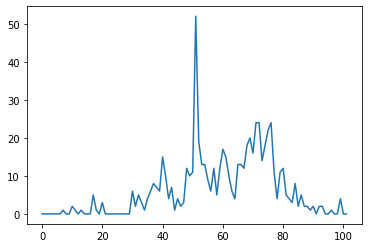

102
102


In [57]:
seoul_day_confirm = []
seoul_day_confirm.append(seoul_confirm_list[0])
for i in range(1, len(seoul_confirm_list)):
    num = seoul_confirm_list[i] - seoul_confirm_list[i-1]
    seoul_day_confirm.append(num)

plt.plot(seoul_day_confirm); plt.show()


print(len(seoul_day_confirm))
print(len(region_date_list))

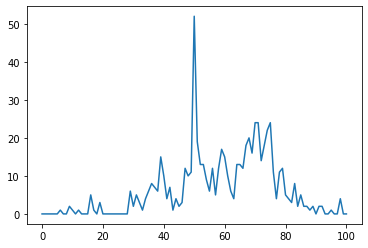

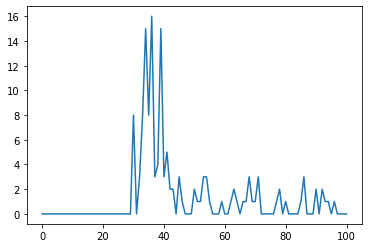

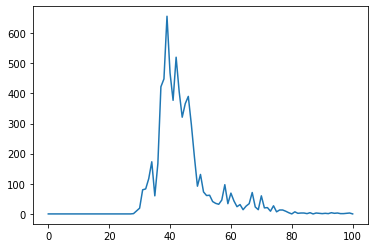

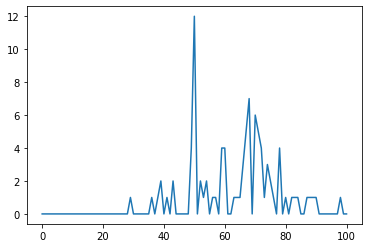

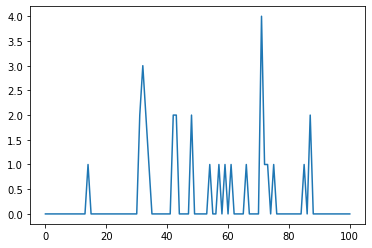

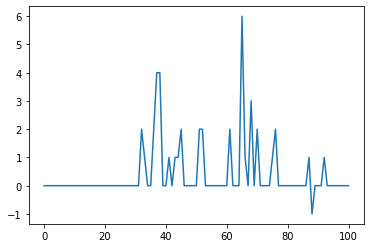

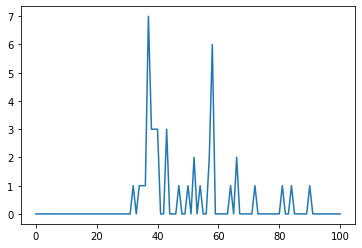

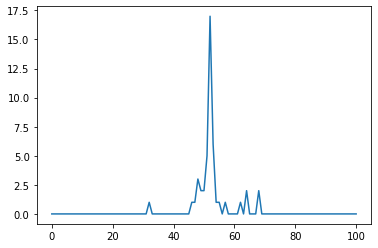

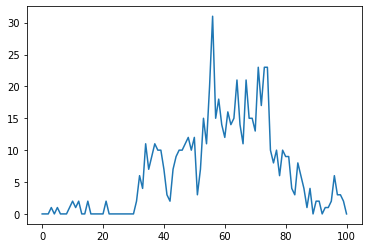

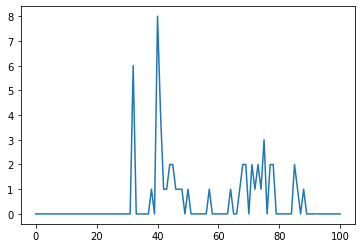

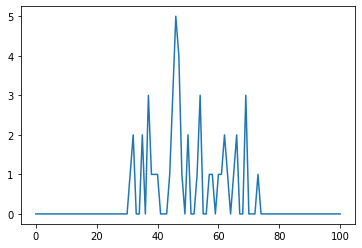

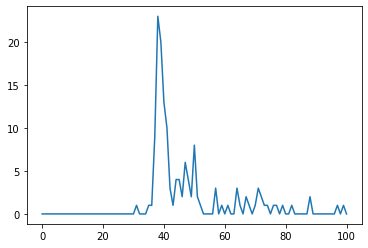

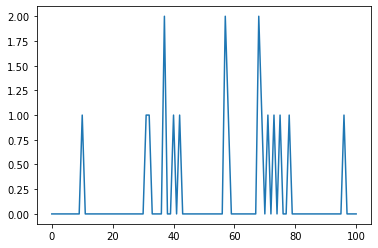

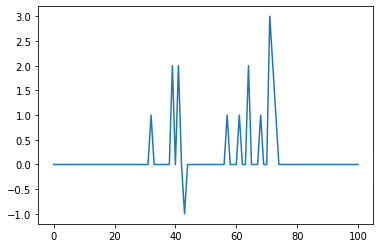

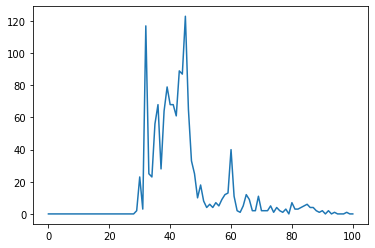

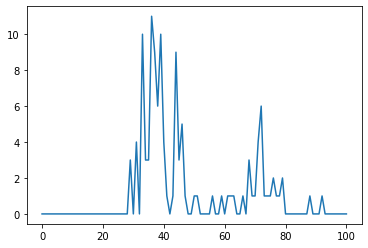

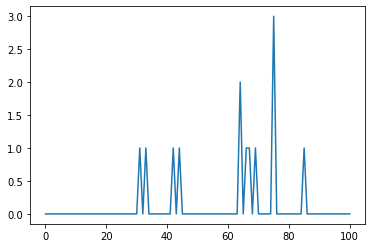

In [58]:
region_day_confirm_list = []


for region_df in region_df_list:
    region_confirm_list = list(region_df['confirmed'])
    region_date_list = list(region_df['date'])
    
    region_day_confirm=[]
    for j in range(1, len(region_confirm_list)):
        num = region_confirm_list[j] - region_confirm_list[j-1]
        region_day_confirm.append(num)
        

    region_day_confirm_list.append(region_day_confirm)
    plt.plot(region_day_confirm); plt.show()
    

In [59]:
region_day_confirm = {}
region_name = list(TimeProvince_data['province'].unique())

for ii in range(len(region_day_confirm_list)):
    region_day_confirm[region_name[ii]] = region_day_confirm_list[ii]

In [60]:
region_day_confirm_df = pd.DataFrame(region_day_confirm)
region_day_confirm_df['date'] = list(seoul_df['date'][1:])
region_day_confirm_df

,Seoul,Busan,Daegu,Incheon,Gwangju,Daejeon,Ulsan,Sejong,Gyeonggi-do,Gangwon-do,Chungcheongbuk-do,Chungcheongnam-do,Jeollabuk-do,Jeollanam-do,Gyeongsangbuk-do,Gyeongsangnam-do,Jeju-do,date
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020-01-21
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020-01-22
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020-01-23
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2020-01-24
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020-01-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0,1,1,0,0,0,0,0,6,0,0,0,1,0,0,0,0,2020-04-26
97,0,0,1,0,0,0,0,0,3,0,0,1,0,0,0,0,0,2020-04-27
98,4,0,2,1,0,0,0,0,3,0,0,0,0,0,1,0,0,2020-04-28
99,0,0,3,0,0,0,0,0,2,0,0,1,0,0,0,0,0,2020-04-29


In [61]:
fig = px.line(region_day_confirm_df, x='date', y=region_day_confirm_df.columns,
              title='Time Series with Rangeslider')

fig.update_xaxes(rangeslider_visible=True)
fig.show()